# QUESTION 1 

# PART A

In [3]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import LatinHypercube

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- PART A: Data Generation ---

# Define the domain
x_domain = (0, 1)
y_domain = (0, 1)

Using device: cuda


# (a) Define the Ground Truth Activation Time T(x, y)

In [4]:

def get_ground_truth_T(x, y):
    """
    Calculates the ground truth activation time T(x, y) based on the given formula.
    T(x, y) = min(sqrt(x^2 + y^2), 0.7 * sqrt((x-1)^2 + (y-1)^2))
    """
    d1 = torch.sqrt(x**2 + y**2)
    d2 = 0.7 * torch.sqrt((x - 1)**2 + (y - 1)**2)
    return torch.min(d1, d2)

# (b) Define the Conduction Velocity V(x, y)

In [5]:

def get_velocity_V(x, y):
    """
    Calculates the conduction velocity V(x, y).
    V is 1.0 where d1 < d2, and 1/0.7 otherwise.
    """
    d1 = torch.sqrt(x**2 + y**2)
    d2 = 0.7 * torch.sqrt((x - 1)**2 + (y - 1)**2)
    # The condition `d1 < d2` is used to define the piecewise velocity.
    # We use torch.where for a differentiable implementation.
    return torch.where(d1 < d2, 1.0, 1.0 / 0.7)

# (c) Generate sparse training samples and collocation points

In [6]:

n_data_points = 30
n_physics_points = 2500  # More points to enforce physics over the domain

# Use Latin Hypercube Sampling for better coverage of the domain
sampler = LatinHypercube(d=2, seed=42)
sample_points = sampler.random(n=n_data_points + n_physics_points)
sample_points = torch.tensor(sample_points, dtype=torch.float32)

# Split into data points (with known T) and physics/collocation points
# Data points are used for the data loss component
train_xy = sample_points[:n_data_points, :].to(device)
train_t = get_ground_truth_T(train_xy[:, 0:1], train_xy[:, 1:2]).to(device)

# Collocation points are used to enforce the Eikonal equation
physics_xy = sample_points[n_data_points:, :].to(device)
# These points need gradients for the physics loss
physics_xy.requires_grad_(True)


tensor([[0.0823, 0.1133],
        [0.4749, 0.5744],
        [0.4203, 0.3369],
        ...,
        [0.3613, 0.1406],
        [0.5136, 0.6108],
        [0.9500, 0.7498]], device='cuda:0', requires_grad=True)

# --- PART B: Model Building and Training ---


# (a) Build a Feedforward Neural Network

In [7]:


class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # A simple but deep enough network to capture the function's complexity
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)



# (b) Train two models: Data-Driven and PINN

In [9]:


def train_model(model, optimizer, epochs, is_pinn=False, lambda_physics=0.1):
    """Generic training loop for both models."""
    model.train()
    loss_history = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()

        # --- Data Loss ---
        # This is common to both models
        t_pred_data = model(train_xy)
        loss_data = nn.functional.mse_loss(t_pred_data, train_t)
        
        total_loss = loss_data
        loss_physics = torch.tensor(0.0) # Initialize for logging

        # --- Physics Loss (only for PINN model) ---
        if is_pinn:
            # Predict T at collocation points
            t_pred_physics = model(physics_xy)

# (c) Use automatic differentiation to compute ||∇T(x,y)||
            # torch.autograd.grad computes the gradient of a scalar output (sum of T)
            # with respect to some inputs (physics_xy).
            grad_t = torch.autograd.grad(
                outputs=t_pred_physics.sum(),
                inputs=physics_xy,
                create_graph=True
            )[0]
            
            # The result grad_t is a tensor of shape [n_physics_points, 2]
            # where each row is (dT/dx, dT/dy)
            grad_t_norm = torch.sqrt(grad_t[:, 0]**2 + grad_t[:, 1]**2)

            # Get the velocity V at the collocation points
            v_physics = get_velocity_V(physics_xy[:, 0], physics_xy[:, 1])

            # Eikonal Residual: R = V * ||∇T|| - 1
            eikonal_residual = v_physics * grad_t_norm - 1.0
            
            # Physics loss is the mean squared error of the residual
            # We want the residual to be close to 0
            loss_physics = nn.functional.mse_loss(eikonal_residual, torch.zeros_like(eikonal_residual))
            
            # Combine losses
            total_loss = loss_data + lambda_physics * loss_physics

        total_loss.backward()
        optimizer.step()
        loss_history.append(total_loss.item())

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss.item():.6f}, "
                  f"Data Loss: {loss_data.item():.6f}, Physics Loss: {loss_physics.item():.6f}")

    return loss_history


In [10]:

# --- Training Model 1: Data-Driven Only ---
print("\n--- Training Model 1: Data-Driven ---")
model_data_driven = PINN().to(device)
optimizer1 = torch.optim.Adam(model_data_driven.parameters(), lr=1e-3)
train_model(model_data_driven, optimizer1, epochs=10000, is_pinn=False)


# --- Training Model 2: Physics-Informed (PINN) ---
print("\n--- Training Model 2: PINN ---")
model_pinn = PINN().to(device)
optimizer2 = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)
# lambda_physics=0.01 is a good starting point to balance the losses
train_model(model_pinn, optimizer2, epochs=10000, is_pinn=True, lambda_physics=0.01)



--- Training Model 1: Data-Driven ---
Epoch [1000/10000], Total Loss: 0.000311, Data Loss: 0.000311, Physics Loss: 0.000000
Epoch [2000/10000], Total Loss: 0.000174, Data Loss: 0.000174, Physics Loss: 0.000000
Epoch [3000/10000], Total Loss: 0.000085, Data Loss: 0.000085, Physics Loss: 0.000000
Epoch [4000/10000], Total Loss: 0.000060, Data Loss: 0.000060, Physics Loss: 0.000000
Epoch [5000/10000], Total Loss: 0.000037, Data Loss: 0.000037, Physics Loss: 0.000000
Epoch [6000/10000], Total Loss: 0.000026, Data Loss: 0.000026, Physics Loss: 0.000000
Epoch [7000/10000], Total Loss: 0.000015, Data Loss: 0.000015, Physics Loss: 0.000000
Epoch [8000/10000], Total Loss: 0.000009, Data Loss: 0.000009, Physics Loss: 0.000000
Epoch [9000/10000], Total Loss: 0.000006, Data Loss: 0.000006, Physics Loss: 0.000000
Epoch [10000/10000], Total Loss: 0.000005, Data Loss: 0.000005, Physics Loss: 0.000000

--- Training Model 2: PINN ---
Epoch [1000/10000], Total Loss: 0.001024, Data Loss: 0.000243, Physi

[0.4889492392539978,
 0.42694517970085144,
 0.36965426802635193,
 0.3171081840991974,
 0.26927268505096436,
 0.2260688692331314,
 0.18741708993911743,
 0.1532573401927948,
 0.12355496734380722,
 0.09829137474298477,
 0.07744424045085907,
 0.060961924493312836,
 0.048733148723840714,
 0.040552545338869095,
 0.03608520328998566,
 0.03483716398477554,
 0.036144502460956573,
 0.0391978845000267,
 0.04311463609337807,
 0.047049667686223984,
 0.05031060054898262,
 0.052435535937547684,
 0.05321487784385681,
 0.05266394093632698,
 0.050966907292604446,
 0.04841162636876106,
 0.04532896727323532,
 0.04204340651631355,
 0.03883790969848633,
 0.03593258187174797,
 0.033475812524557114,
 0.03154497221112251,
 0.030154358595609665,
 0.02926749922335148,
 0.028811577707529068,
 0.028691917657852173,
 0.028805231675505638,
 0.029050536453723907,
 0.029337512329220772,
 0.029591988772153854,
 0.029758991673588753,
 0.029803575947880745,
 0.029709914699196815,
 0.02947903797030449,
 0.0291258171200752

# --- PART C: Compare ground truth and predictions ---

In [11]:


# (a) Create a grid for plotting and evaluation
grid_size = 100
x = torch.linspace(x_domain[0], x_domain[1], grid_size)
y = torch.linspace(y_domain[0], y_domain[1], grid_size)
X, Y = torch.meshgrid(x, y, indexing='ij')
xy_grid = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)

# Get predictions from both models on the grid
model_data_driven.eval()
model_pinn.eval()
with torch.no_grad():
    T_pred_data_driven = model_data_driven(xy_grid).reshape(grid_size, grid_size).cpu().numpy()
    T_pred_pinn = model_pinn(xy_grid).reshape(grid_size, grid_size).cpu().numpy()

# Get the ground truth on the grid
T_true = get_ground_truth_T(X, Y).cpu().numpy()

# (b) Calculate Root Mean Squared Error (RMSE) for each model
rmse_data_driven = np.sqrt(np.mean((T_pred_data_driven - T_true)**2))
rmse_pinn = np.sqrt(np.mean((T_pred_pinn - T_true)**2))

print(f"\n--- Evaluation ---")
print(f"RMSE (Data-Driven Model): {rmse_data_driven:.6f}")
print(f"RMSE (PINN Model): {rmse_pinn:.6f}")



--- Evaluation ---
RMSE (Data-Driven Model): 0.014299
RMSE (PINN Model): 0.009657


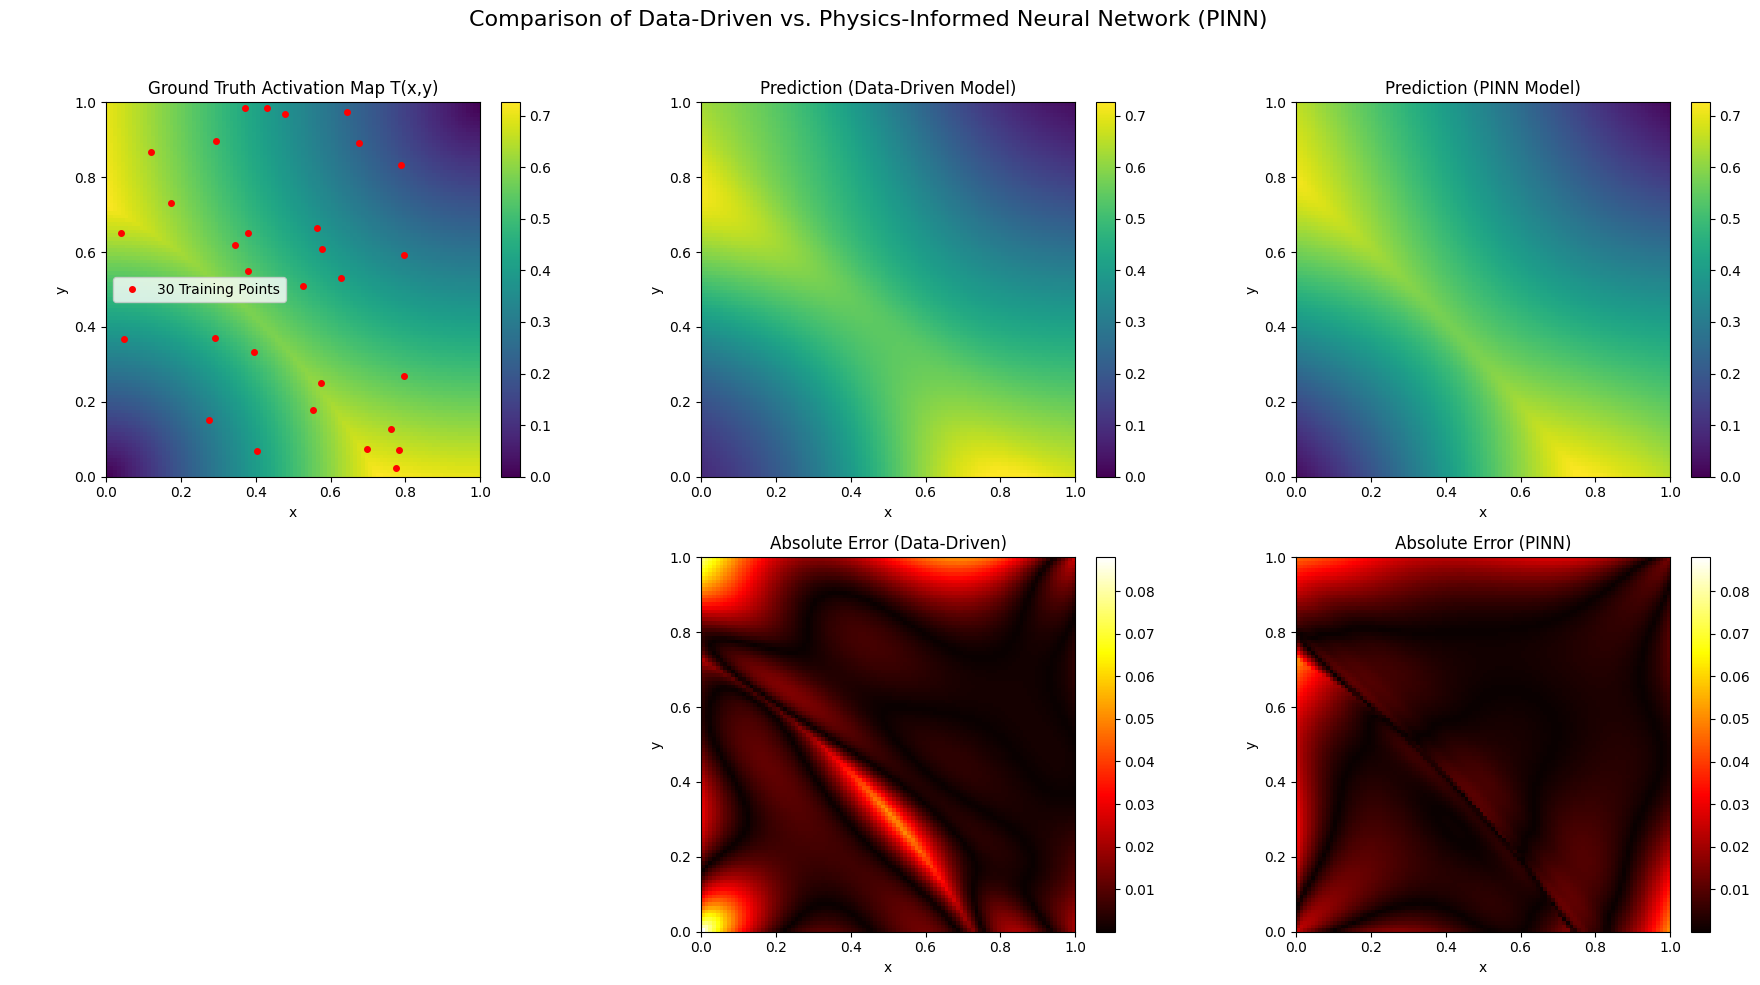

In [14]:

# (c) Plot the results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparison of Data-Driven vs. Physics-Informed Neural Network (PINN)', fontsize=16)

# Plotting function
def plot_map(ax, data, title, is_error=False, vmin=None, vmax=None):
    if is_error:
        cmap = 'hot'
    else:
        cmap = 'viridis'
        vmin = T_true.min()
        vmax = T_true.max()
        
    im = ax.imshow(data, extent=[x_domain[0], x_domain[1], y_domain[0], y_domain[1]], 
                   origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    return im

# Row 1: Activation Maps
plot_map(axes[0, 0], T_true, 'Ground Truth Activation Map T(x,y)')
# Show the sparse training points on the ground truth plot
axes[0, 0].plot(train_xy.cpu()[:, 0], train_xy.cpu()[:, 1], 'ro', markersize=4, label=f'{n_data_points} Training Points')
axes[0, 0].legend()

plot_map(axes[0, 1], T_pred_data_driven, 'Prediction (Data-Driven Model)')
plot_map(axes[0, 2], T_pred_pinn, 'Prediction (PINN Model)')

# Row 2: Error Maps
error_data_driven = np.abs(T_pred_data_driven - T_true)
error_pinn = np.abs(T_pred_pinn - T_true)
vmax_err = max(error_data_driven.max(), error_pinn.max())

axes[1, 0].axis('off') # Empty plot for alignment
plot_map(axes[1, 1], error_data_driven, 'Absolute Error (Data-Driven)', is_error=True, vmax=vmax_err)
plot_map(axes[1, 2], error_pinn, 'Absolute Error (PINN)', is_error=True, vmax=vmax_err)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()